# Figure 3: population variations

In [13]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from tabulate import tabulate
import h5py
from astropy.cosmology import Planck18 as cosmo
from astropy.cosmology import z_at_value
import astropy.units as u
import scipy
from scipy import stats
from scipy.integrate import cumtrapz
from scipy.ndimage import gaussian_filter as gf
from matplotlib.lines import Line2D
import pandas
import corner
import sympy as sp
import os
from scipy.interpolate import RegularGridInterpolator
from functions import * 
import sys
sys.path.insert(0, '../COMPAS')
from spin_class import * 

distribution = 'NOT fixed' #fixed or 'NOT fixed'
DCOtype='BHNS'
poptype='A'

if poptype == 'A':
    w_type='w_000'
    r0 = 149 #43
    w_type_high = 'w_000'
    r0_high = 302 #200
    w_type_low = 'w_000'
    r0_low = 62
    
if poptype == 'B':
    w_type='w_000'
    r0 = 20
    w_type_high = 'w_231'
    r0_high = 100
    w_type_low = 'w_312'
    r0_low = 10

num = 1000000
spins = ['Zero','Uniform']
marker_style = ['^','o']
inside_style = [None,'w']
eos = ["SFHo","DD2"]
runs = ["O4","O5"]

Loading intrinsic population
Loading GW population
Loading EM population (kilonova)
Loading EM population (GRB afterglow)
Loading EM population (GRB prompt)
Computing weights
Computing weights
Computing weights

EoS: SFHo
Population model: A
The mass and spin distributions are NOT fixed
The spin prescription is: Zero

Computing GW limiting thresholds
Computing KN limiting thresholds
Computing GRB AFTERGLOW limiting thresholds
Computing GRB PROMPT limiting thresholds
Plotting detection rates
0.007735180969919009 0.01360324929192598
0.008684379373276265 0.008979734488476164
[[0.00868438]
 [0.01360325]]
Computing weights
Computing weights
Computing weights

EoS: SFHo
Population model: A
The mass and spin distributions are NOT fixed
The spin prescription is: Uniform

Computing GW limiting thresholds
Computing KN limiting thresholds
Computing GRB AFTERGLOW limiting thresholds
Computing GRB PROMPT limiting thresholds
Plotting detection rates
0.03144344346008472 0.05529709022290534
0.01265046

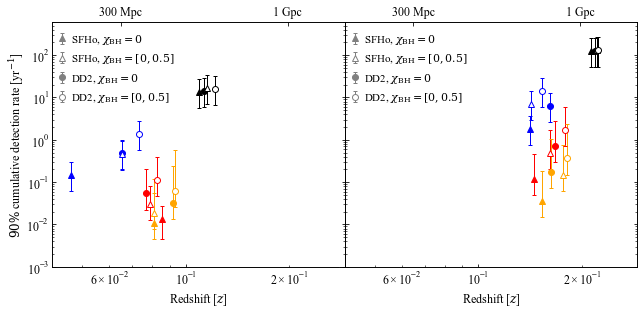

In [14]:
#recomp_gaussian = False
#recomp_uniform = False
plt.rcParams['font.family']="Times New Roman"
#plt.rcParams['font.size'] = 11
plt.rcParams['figure.figsize']=9.5,4.5
#plt.rcParams['figure.autolayout']=True
plt.rcParams['mathtext.fontset']='dejavuserif'
#plt.rcParams["axes.axisbelow"] = False
plt.rcParams['legend.handlelength'] = 0

gs_kw = dict(width_ratios=[1, 1])
fig1,ax = plt.subplots(1,2,gridspec_kw=gs_kw)
fig1.subplots_adjust(wspace=0.,right=0.98)

for h in range(len(runs)):
    if h == 0:
        lim_snr = 12.
        
        lim_kn = np.array([22.,22.,21.])
        
        lim_grb = np.asarray([0.1,5.7e-3,1.5e-6])
        
        lim_prompt_fermi = 4.
        lim_prompt_swift = 3.5
        
    if h == 1:
        lim_snr = 12.
        
        lim_kn = np.array([26.,24.4,21.])
        
        lim_grb = np.asarray([1.e-2,1.5e-4,1.5e-6])
        
        lim_prompt_fermi = 4.
        lim_prompt_swift = 3.5

    for k in range(len(eos)):
        if k == 0:
            mns_max = 2.058838
        if k == 1:
            mns_max = 2.422658
        table = h5py.File('./population_data/bhns_%i_%s_z10_mass_spin_thv_GWFAST.hdf5' %(num,eos[k]),'r')
        
        path = './population_data/COMPASCompactOutput_'+ DCOtype + '_' + poptype+'.h5' # change this line!
        
        ### --- Loading Population --- ###
        
        print("Loading intrinsic population")
        mbh = table['mbh'][()]
        mns = table['mns'][()]
        lamb_ns = table['lamb_ns'][()]
        spin_bh = table['spin_bh'][()]
        #i_tilt = table['i_tilt'][()]
        z = table['z'][()]
        dL = table['dL'][()]
        thv = table['thv'][()]
        ra = table['ra'][()]
        dec = table['dec'][()]
        #pol = table['pol'][()]
        m_dyn = table['m_dyn'][()]
        v_dyn = table['v_dyn'][()]
        m_disk = table['m_disk'][()]
        m_out = table['m_out'][()]
        final_x = table['final_x'][()]
        E_bkt = table['E_bkt'][()]
        E_k_jet = table['E_k_jet'][()]
        Ec = table['Ec'][()]
        
        print("Loading GW population")
        snr_LVKO4 = table['snr_LVKO4'][()]
        snr_LVKO4_duty = table['snr_LVKO4_duty'][()]
        snr_LVKIO5 = table['snr_LVKIO5'][()]
        snr_LVKIO5_duty = table['snr_LVKIO5_duty'][()]
        
        print("Loading EM population (kilonova)")
        kn_waves = table['kn_waves'][()]
        #kn_waves=np.asarray([484.,900.,1250.])
        t_kn = table['t_kn'][()]
        lc_kn = table['lc_kn'][()]
        
        print("Loading EM population (GRB afterglow)")
        grb_nu = table['grb_nu'][()]
        t_grb = table['t_grb'][()]
        th = table['th'][()]
        lc_grb = table['lc_grb'][()]
        
        print("Loading EM population (GRB prompt)")
        prompt_band = table['prompt_band'][()]
        flux_prompt = table['flux_prompt'][()]
        
        table.close()
        
        for i in range (len(spins)):
            spin_prescription = spins[i]
            spin = calculate_spin_olderCOMPASdata(data_path=path)
            if spin_prescription == 'Bavera21':
                spinM1, spinM2  = spin.Bavera21()
            if spin_prescription == 'Qin21':
                spinM1, spinM2  = spin.Qin21()
            if spin_prescription == 'Uniform':
                spinM1, spinM2  = spin.Bavera21()
                spinM1 = np.random.uniform(0.,0.5,spinM1.shape)
                spinM2 = np.random.uniform(0.,0.5,spinM2.shape)
            elif spin_prescription == 'Zero':
                spinM1, spinM2  = spin.Bavera21()
                spinM1 = np.random.uniform(0.,0.,spinM1.shape)
                spinM2 = np.random.uniform(0.,0.,spinM2.shape)
            
            bhx=[2.5,27]
            nsx=[1.1,3]
            spinx=[0.,1.]
            binsx=50
            binsy=50
            binsz=50
            
               
            if distribution == 'fixed':
                C_mc, w = f_weights_fixed(mbh,mns,thv,spin_bh,z,r0,5.e-2,path,w_type,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
                C_mc_low, w_low = f_weights_fixed(mbh,mns,thv,spin_bh,z,r0_low,5.e-2,path,w_type_low,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
                C_mc_high, w_high = f_weights_fixed(mbh,mns,thv,spin_bh,z,r0_high,5.e-2,path,w_type_high,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
                
            
            if distribution == 'NOT fixed':
                C_mc, w = f_weights(mbh,mns,thv,spin_bh,z,r0,path,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
                C_mc_low, w_low = f_weights(mbh,mns,thv,spin_bh,z,r0_low,path,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
                C_mc_high, w_high = f_weights(mbh,mns,thv,spin_bh,z,r0_high,path,spinM1,spinM2,bhx,nsx,spinx,binsx,binsy,binsz)
            
            print("")
            print("EoS:",eos[k])
            print("Population model:",poptype)
            print("The mass and spin distributions are", distribution)
            if distribution == 'fixed':
                print("The fiducial SFRD is", w_type, "with r0 =", r0)
                print("The higher limit SFRD is", w_type_high, "with r0 =", r0_high)
                print("The lower limit SFRD is", w_type_low, "with r0 =", r0_low)
            print("The spin prescription is:", spin_prescription)
            print("")
            
            #GW
            print("Computing GW limiting thresholds")
            np.random.seed(0)
    
            if h == 0:
                snr_O4 = snr_LVKO4_duty
                gw_det = snr_O4 >= lim_snr
            
            if h == 1:
                snr_O5 = snr_LVKIO5_duty
                gw_det = snr_O5 >= lim_snr
            
    
            #KILONOVA
            print("Computing KN limiting thresholds")
            kn_peak = np.min(lc_kn, axis=2)
            kn_det = np.zeros([num,len(kn_waves)],dtype=bool)
            for j in range(len(kn_waves)):
                kn_peak_APP = abs_to_app(kn_peak[:,j],dL[:]*1.e6)
                kn_det[:,j] = kn_peak_APP <= lim_kn[j]
            kn_det_all = np.max(kn_det, axis = 1)
            kn_det_g = kn_det[:,0]
            kn_det_r = kn_det[:,1]
            kn_det_J = kn_det[:,2]
            
            #GRB AFTERGLOW
            print("Computing GRB AFTERGLOW limiting thresholds")
            grb_peak = np.max(lc_grb, axis=2)
            grb_det = np.zeros([num,len(grb_nu)],dtype=bool)
            grb_det_15 = np.zeros([num,len(grb_nu)],dtype=bool)
            for j in range(len(grb_nu)):
                grb_det[:,j] = grb_peak[:,j,0] >= lim_grb[j]
                grb_det_15[:,j] = grb_peak[:,j,1] >= lim_grb[j]
            grb_det_all = np.max(grb_det, axis = 1)
            grb_det_radio = grb_det[:,0]
            grb_det_radio_15 = grb_det_15[:,0]
            grb_det_optic = grb_det[:,1]
            grb_det_x = grb_det[:,2]
            
            #GRB PROMPT
            print("Computing GRB PROMPT limiting thresholds")
            prompt_det_fermi = flux_prompt[:,0,0] >= lim_prompt_fermi ######CHANGE THIS LINE
            prompt_det_fermi_15 = flux_prompt[:,0,1] >= lim_prompt_fermi
            
            ### --- Computing detection Rates --- ###
            
            x = np.sort(z)
            s = np.argsort(z)
            
            #ALL NSNS
            cum_tot = C_mc*np.cumsum(w[s])
            cum_tot_high = C_mc_high*np.cumsum(w_high[s])
            cum_tot_low = C_mc_low*np.cumsum(w_low[s])
            
            #GW
            #cum_gw_O3 = C_mc*np.cumsum(w[s]*gw_det_O3[s])
            cum_gw = C_mc*np.cumsum(w[s]*gw_det[s])
            cum_gw_norm = cum_gw/cum_gw[-1]
            cum_gw_high = C_mc_high*np.cumsum(w_high[s]*gw_det[s])
            cum_gw_low = C_mc_low*np.cumsum(w_low[s]*gw_det[s])
            
            #KN
            cum_gw_kn_g = C_mc*np.cumsum(w[s]*kn_det_g[s]*gw_det[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
            cum_gw_kn_g_high = C_mc_high*np.cumsum(w_high[s]*kn_det_g[s]*gw_det[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
            cum_gw_kn_g_low = C_mc_low*np.cumsum(w_low[s]*kn_det_g[s]*gw_det[s]*((m_disk[s]>1.e-5)|(m_dyn[s]>1.e-6))) 
            cum_gw_kn_g_norm = cum_gw_kn_g/cum_gw_kn_g[-1]
            
            #GRB AFTERGLOW
            cum_gw_grb_radio =  C_mc*np.cumsum(w[s]*grb_det_radio[s]*gw_det[s])
            cum_gw_grb_radio_high =  C_mc_high*np.cumsum(w_high[s]*grb_det_radio[s]*gw_det[s])
            cum_gw_grb_radio_low =  C_mc_low*np.cumsum(w_low[s]*grb_det_radio[s]*gw_det[s])
            cum_gw_grb_radio_norm = cum_gw_grb_radio/cum_gw_grb_radio[-1]
            cum_gw_grb_radio_15 =  C_mc*np.cumsum(w[s]*grb_det_radio[s]*gw_det[s])
            cum_gw_grb_radio_high_15 =  C_mc_high*np.cumsum(w_high[s]*grb_det_radio_15[s]*gw_det[s])
            cum_gw_grb_radio_low_15 =  C_mc_low*np.cumsum(w_low[s]*grb_det_radio_15[s]*gw_det[s])
                
            #GRB PROMPT 
            #cum_fermi = C_mc*np.cumsum(w[s]*prompt_det_fermi[s]) 
            cum_gw_fermi = C_mc*np.cumsum(w[s]*prompt_det_fermi[s]*gw_det[s])
            cum_gw_fermi_15 = C_mc*np.cumsum(w[s]*prompt_det_fermi_15[s]*gw_det[s])
            cum_gw_fermi_norm = cum_gw_fermi/cum_gw_fermi[-1]
            cum_gw_fermi_15 = C_mc*np.cumsum(w[s]*prompt_det_fermi_15[s]*gw_det[s])
            cum_gw_fermi_15_norm = cum_gw_fermi_15/cum_gw_fermi_15[-1]
            cum_gw_fermi_high = C_mc_high*np.cumsum(w_high[s]*prompt_det_fermi[s]*gw_det[s])
            cum_gw_fermi_low = C_mc_low*np.cumsum(w_low[s]*prompt_det_fermi[s]*gw_det[s])
            cum_gw_fermi_high_15 = C_mc_high*np.cumsum(w_high[s]*prompt_det_fermi_15[s]*gw_det[s])
            cum_gw_fermi_low_15 = C_mc_low*np.cumsum(w_low[s]*prompt_det_fermi_15[s]*gw_det[s])
            
            ### --- Plotting detection Rates --- ###
            print("Plotting detection rates")
            skip = 30000
            skip2 = 1
            perc = 0.9
            xgw = np.interp(perc,cum_gw_norm[::skip],x[::skip])
            ygw = np.interp(xgw,x[::skip],cum_gw[::skip])
            xkn = np.interp(perc,cum_gw_kn_g_norm[::skip2],x[::skip2])
            ykn = np.interp(xkn,x[::skip],cum_gw_kn_g[::skip])
            xfermi = np.interp(perc,cum_gw_fermi_norm[::skip],x[::skip])
            yfermi = np.interp(xfermi,x[::skip],cum_gw_fermi[::skip]*0.6)
            #xgrb = 10**(np.interp(np.log10(perc),np.log10(cum_gw_grb_radio_norm[::skip]),np.log10(x[::skip])))
            xgrb = np.interp(perc,cum_gw_grb_radio_norm[::skip],x[::skip])
            ygrb = np.interp(xgrb,x[::skip],cum_gw_grb_radio[::skip])
            
            errorGW_low = np.interp(xgw,x[::skip],cum_gw[::skip]) - np.interp(xgw,x[::skip],cum_gw_low[::skip])
            errorGW_high = np.interp(xgw,x[::skip],cum_gw_high[::skip]) - np.interp(xgw,x[::skip],cum_gw[::skip])
            errorGW = np.array([[errorGW_low,errorGW_high]]).T
            
            errorKN_low = np.interp(xkn,x[::skip],cum_gw_kn_g[::skip]) - np.interp(xkn,x[::skip],cum_gw_kn_g_low[::skip])
            errorKN_high = np.interp(xkn,x[::skip],cum_gw_kn_g_high[::skip]) - np.interp(xkn,x[::skip],cum_gw_kn_g[::skip])
            errorKN = np.array([[errorKN_low,errorKN_high]]).T
            
            errorGRB_low = np.interp(xgrb,x[::skip],cum_gw_grb_radio[::skip]) - np.interp(xgrb,x[::skip],cum_gw_grb_radio_low[::skip])
            errorGRB_high = np.interp(xgrb,x[::skip],cum_gw_grb_radio_high[::skip]) - np.interp(xgrb,x[::skip],cum_gw_grb_radio[::skip])
            
            print(errorGRB_low,errorGRB_high)
            
            errorGRB_low_15 = np.interp(xgrb,x[::skip],cum_gw_grb_radio_15[::skip]) - np.interp(xgrb,x[::skip],cum_gw_grb_radio_low_15[::skip])
            errorGRB_high_15 = np.interp(xgrb,x[::skip],cum_gw_grb_radio_high_15[::skip]) - np.interp(xgrb,x[::skip],cum_gw_grb_radio_15[::skip])
            errorGRB = np.array([[np.maximum(errorGRB_low,errorGRB_low_15),np.maximum(errorGRB_high,errorGRB_high_15)]]).T
    
            print(errorGRB_low_15,errorGRB_high_15)
            print(errorGRB)
        
            errorFERMI_low = np.interp(xfermi,x[::skip],cum_gw_fermi[::skip]*0.6) - np.interp(xfermi,x[::skip],cum_gw_fermi_low[::skip]*0.6)
            errorFERMI_high = np.interp(xfermi,x[::skip],cum_gw_fermi_high[::skip]*0.6) - np.interp(xfermi,x[::skip],cum_gw_fermi[::skip]*0.6)
            
            errorFERMI_low_15 = np.interp(xfermi,x[::skip],cum_gw_fermi_15[::skip]*0.6) - np.interp(xfermi,x[::skip],cum_gw_fermi_low_15[::skip]*0.6)
            errorFERMI_high_15 = np.interp(xfermi,x[::skip],cum_gw_fermi_high_15[::skip]*0.6) - np.interp(xfermi,x[::skip],cum_gw_fermi_15[::skip]*0.6)
            errorFERMI = np.array([[np.minimum(errorFERMI_low,errorFERMI_low_15),np.maximum(errorFERMI_high,errorFERMI_high_15)]]).T
  
            ax[h].errorbar(xgw,ygw,c='black',marker=marker_style[i],yerr=errorGW,elinewidth=1,capsize=2,mfc=inside_style[k])
            ax[h].errorbar(xkn,ykn,c='blue',marker=marker_style[i],yerr=errorKN,elinewidth=1,capsize=2,mfc=inside_style[k])
            ax[h].errorbar(xfermi,yfermi,ls="-",c='orange',marker=marker_style[i],yerr=errorFERMI,elinewidth=1,capsize=2,mfc=inside_style[k])
            ax[h].errorbar(xgrb,ygrb,ls="-",c='red',marker=marker_style[i],yerr=errorGRB,elinewidth=1,capsize=2,mfc=inside_style[k])
          
    #ax.loglog(x,cum_tot,c='silver',linewidth=1.6,zorder=1)
    #ax.fill_between(x[::10],cum_tot_high[::10],cum_tot_low[::10],color='silver',alpha=0.3,edgecolor="None",zorder=1)
    
    ax[h].errorbar(1000,100000,ls="-",c='grey',marker="^",yerr=1.,elinewidth=1,capsize=2,mfc=None,label="SFHo, $\chi_\mathrm{BH} = 0$")
    ax[h].errorbar(1000,100000,ls="-",c='grey',marker="^",yerr=1.,elinewidth=1,capsize=2,mfc="w",label="SFHo, $\chi_\mathrm{BH} = [0,0.5]$")
    ax[h].errorbar(1000,100000,ls="-",c='grey',marker="o",yerr=1.,elinewidth=1,capsize=2,mfc=None,label="DD2, $\chi_\mathrm{BH} = 0$")
    ax[h].errorbar(1000,100000,ls="-",c='grey',marker="o",yerr=1.,elinewidth=1,capsize=2,mfc="w",label="DD2, $\chi_\mathrm{BH} = [0,0.5]$")
    ax[h].legend(loc=2,frameon=False,prop={'size': 11})
    
    ylim = (0.001,600.)
    xlim = (0.041,0.29)
    ax[h].set_xlabel('Redshift [$z$]',size=12)
    if h == 0:
        ax[h].set_ylabel(r'$90\%$ cumulative detection rate [yr$^{-1}$]',size=12)
    ax[h].set_ylim(ylim)
    ax[h].set_xlim(xlim)
    #ax.set_xticks([0.01,0.1])
    ax[h].minorticks_on()
    #ax.legend(loc=2,frameon=False,prop={'size': 11})
    ax2 = ax[h].twiny()
    ax2.set_xlim(xlim)
    ax2.set_xscale('log')
    ax2.set_yscale('log')
    ax2.minorticks_off()
    ax2.set_xticks([0.0647,0.198])
    ax2.set_xticklabels(('300 Mpc','1 Gpc'),size=12)
    #ax2.set_xlabel('Luminosity distance $d_\mathrm{L}$',size=11)
    if h == 1:
        ax[h].tick_params(axis = 'y',direction='in',which='both',right=True,labelsize=0,labelcolor="white",zorder=2)
        ax[h].tick_params(axis = 'x',direction='in',which='both',labelsize=12)
    if h == 0:
        ax[h].tick_params(direction='in',which='both',right=True,labelsize=12,zorder=2)
    ax2.tick_params(direction='in',which='both',zorder=2)
    ax[h].yaxis.labelpad = 0.1
    
    ax[h].set_yscale('log')
    ax[h].set_xscale('log')

plt.show()